# Amazon electronic procducts descriptive analysis

- Source: Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/)

The repository has several datasets. For this case study, we are using the Electronics
dataset.


In [1]:
import os
import json
import gzip
from tqdm.notebook import tqdm as tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

RANDOM = 2021

figure_path = '/home/weiss/git/thesis/doc/figures/'

In [2]:
DIR = '/home/weiss/rs_data/amazon-electronic-product-recommendation/'
PATH_IN = os.path.join(DIR, 'Electronics.json.gz')
PATH_META = os.path.join(DIR, 'meta_Electronics.json.gz')

In [3]:
### load the meta data

def load_data(file, limit_data=False):
    data = []
    with gzip.open(file) as f:
        i = 0
        for l in tqdm(f):
            data.append(json.loads(l.strip()))
            if i >= 100000 and limit_data == True:
                break
            i +=1
    return pd.DataFrame.from_dict(data)

In [4]:
ratings = load_data(PATH_IN)
print(ratings.head())
print(ratings.shape)


   overall  verified   reviewTime      reviewerID        asin  \
0      5.0      True  07 17, 2002  A1N070NS9CJQ2I  0060009810   
1      5.0     False   07 6, 2002  A3P0KRKOBQK1KN  0060009810   
2      5.0     False   07 3, 2002  A192HO2ICJ75VU  0060009810   
3      4.0     False  06 30, 2002  A2T278FKFL3BLT  0060009810   
4      5.0     False  06 28, 2002  A2ZUXVTW8RXBXW  0060009810   

                       style reviewerName  \
0  {'Format:': ' Hardcover'}   Teri Adams   
1  {'Format:': ' Hardcover'}     Willa C.   
2  {'Format:': ' Hardcover'}          Kit   
3  {'Format:': ' Hardcover'}       Andres   
4  {'Format:': ' Hardcover'}         John   

                                          reviewText  \
0  This was the first time I read Garcia-Aguilera...   
1  As with all of Ms. Garcia-Aguilera's books, I ...   
2  I've not read any of Ms Aguilera's works befor...   
3  This romance novel is right up there with the ...   
4  Carolina Garcia Aguilera has done it again.  S...   



In [5]:
meta = load_data(PATH_META, limit_data=True)
print(meta.head())
print(meta.shape)


                                            category tech1  \
0  [Electronics, Camera &amp; Photo, Video Survei...         
1                  [Electronics, Camera &amp; Photo]         
2  [Electronics, eBook Readers &amp; Accessories,...         
3  [Electronics, eBook Readers & Accessories, eBo...         
4  [Electronics, eBook Readers & Accessories, eBo...         

                                         description fit  \
0  [The following camera brands and models have b...       
1  [This second edition of the Handbook of Astron...       
2  [A zesty tale. (Publishers Weekly)<br /><br />...       
3                                                 []       
4  [&#8220;sex.lies.murder.fame. is brillllli&#82...       

                                               title  \
0  Genuine Geovision 1 Channel 3rd Party NVR IP S...   
1  Books "Handbook of Astronomical Image Processi...   
2                                     One Hot Summer   
3  Hurray for Hattie Rabbit: Story and pi

In [6]:
processed_ratings = ratings[['reviewerID', 'asin','overall']]
processed_ratings.columns = ['user_id', 'item_id', 'rating']
display(processed_ratings.head())

,user_id,item_id,rating
0,A1N070NS9CJQ2I,0060009810,5.0
1,A3P0KRKOBQK1KN,0060009810,5.0
2,A192HO2ICJ75VU,0060009810,5.0
3,A2T278FKFL3BLT,0060009810,4.0
4,A2ZUXVTW8RXBXW,0060009810,5.0


In [7]:
print('# users: ', processed_ratings['user_id'].unique().size)
print('# items: ', processed_ratings['item_id'].unique().size)
print('# ratings: ', processed_ratings['rating'].size)

# users:  9838676
# items:  756489
# ratings:  20994353


user_id
A680RUE1FDO8B     633
A3OXHLG6DIBRW8    593
ADLVFFE4VBT8      549
A1X1CEGHTHMBL1    498
A6FIAB28IS79      491
                 ... 
A2JNTVQIKGB5O1      1
A2JNTURHIY1LIN      1
A2JNTSQZZE069Q      1
A2JNTLW8Q6SFKZ      1
A2W4MUCX8DW4Q9      1
Length: 9838676, dtype: int64
<class 'pandas.core.series.Series'>
9838676


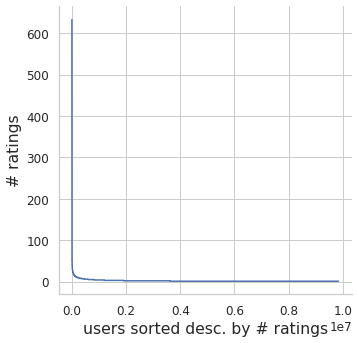

In [8]:
# power law?
rating_count_by_user = processed_ratings.groupby('user_id').size().sort_values(ascending=False)
print(rating_count_by_user)
print(type(rating_count_by_user))
size = rating_count_by_user.size
print(size)

df = pd.DataFrame(dict(sorted_user_id=range(1,size+1), rating_counts=rating_count_by_user.values))

sns.set(style='whitegrid', font_scale=1.3, rc={'xtick.labelsize':12, 'ytick.labelsize':12})
image = sns.relplot(data=df,
                    x="sorted_user_id",
                    y="rating_counts",
                    kind="line",
                    )

image.set(xlabel="users sorted desc. by # ratings",
          ylabel="# ratings"
          )


image.savefig(figure_path + '/amazon-long-tail-distribution.png', dpi=300, bbox_inches='tight')

In [9]:
# Keep entries where the user has rated more than n items and less than m items

n = 50
m = 1000

counts = processed_ratings['user_id'].value_counts()
mask = (counts >= n) & (counts <= m)
print(mask.value_counts())
processed_ratings_cut = processed_ratings[processed_ratings['user_id'].isin(mask[mask == True].index)]

False    9833533
True        5143
Name: user_id, dtype: int64


user_id
A680RUE1FDO8B     633
A3OXHLG6DIBRW8    593
ADLVFFE4VBT8      549
A1X1CEGHTHMBL1    498
A6FIAB28IS79      491
                 ... 
AL3JCDQ3DTGFE      50
A2Y3FNMRNCDFUA     50
A26OALL5BYR5UH     50
A3RKGFB4T4NBCL     50
AFZLQ3QNRGOZM      50
Length: 5143, dtype: int64
<class 'pandas.core.series.Series'>
5143


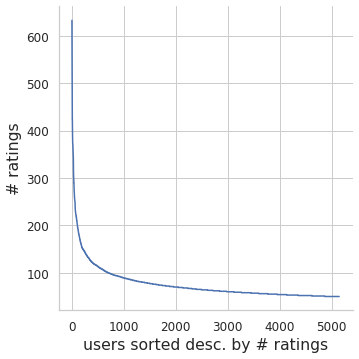

In [10]:
# power law?
rating_count_by_user = processed_ratings_cut.groupby('user_id').size().sort_values(ascending=False)
print(rating_count_by_user)
print(type(rating_count_by_user))
size = rating_count_by_user.size
print(size)

df = pd.DataFrame(dict(sorted_user_id=range(1,size+1), rating_counts=rating_count_by_user.values))

sns.set(style='whitegrid', font_scale=1.3, rc={'xtick.labelsize':12, 'ytick.labelsize':12})
image = sns.relplot(data=df,
                    x="sorted_user_id",
                    y="rating_counts",
                    kind="line",
                    )

image.set(xlabel="users sorted desc. by # ratings",
          ylabel="# ratings"
          )


image.savefig(figure_path + '/amazon-long-tail-distribution-cut.png', dpi=300, bbox_inches='tight')

In [11]:
processed_ratings_cut['rating'] = processed_ratings_cut['rating'].values.astype(int)

print(processed_ratings_cut['rating'])
print(processed_ratings_cut['rating'].size)

222         4
306         5
380         5
649         5
743         3
           ..
20993431    5
20993438    5
20993495    5
20993689    4
20993740    4
Name: rating, Length: 394059, dtype: int64
394059


/home/weiss/.conda/envs/GNN/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/home/weiss/.conda/envs/GNN/lib/python3.7/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/weiss/.conda/envs/GNN/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


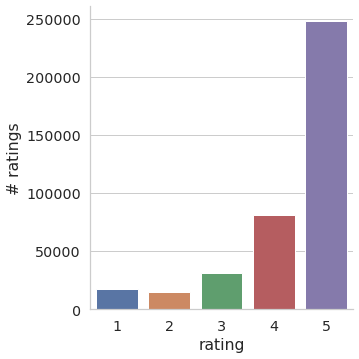

In [12]:
# rating distribution after cleanup
sns.set(style='whitegrid', font_scale=1.3)
g = sns.factorplot("rating", data=processed_ratings_cut, kind='count')
g.set_ylabels("# ratings")
g.savefig(figure_path + '/amazon-rating-distribution.png', dpi=300, bbox_inches='tight')

In [13]:
processed_ratings_cut['rating'].mean()

4.340865200388774

In [14]:
processed_ratings_cut['rating'].median()

5.0

In [15]:
# save processed ratings as pickle
processed_ratings_cut.to_pickle(DIR+'amazon-electronic-ratings.pkl')